In [1]:
import os
import numpy as np

data_dir = '../datasets/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

with open(fname) as f:
    data = f.read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [2]:
def generator(data, lookback, delay, min_index, max_index, 
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        yield samples, targets

In [3]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, 
                      lookback=lookback, 
                      delay=delay, 
                      min_index=0, 
                      max_index=200000, 
                      shuffle=True, 
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data, 
                    lookback=lookback, 
                    delay=delay, 
                    min_index=200001, 
                    max_index=300000, 
                    step=step, 
                    batch_size=batch_size)
test_gen = generator(float_data, 
                     lookback=lookback, 
                     delay=delay, 
                     min_index=300001, 
                     max_index=None, 
                     step=step, 
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [4]:
import matplotlib.pyplot as plt

def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0005), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20, 
                    validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 49s 96ms/step - loss: 0.3141 - val_loss: 0.2724
Epoch 2/20
500/500 [==============================] - 47s 95ms/step - loss: 0.2873 - val_loss: 0.2695
Epoch 3/20
500/500 [==============================] - 47s 95ms/step - loss: 0.2838 - val_loss: 0.2648
Epoch 4/20
500/500 [==============================] - 47s 95ms/step - loss: 0.2780 - val_loss: 0.2630
Epoch 5/20
500/500 [==============================] - 47s 94ms/step - loss: 0.2765 - val_loss: 0.2613
Epoch 6/20
500/500 [==============================] - 47s 94ms/step - loss: 0.2736 - val_loss: 0.2699
Epoch 7/20
500/500 [==============================] - 47s 94ms/step - loss: 0.2725 - val_loss: 0.2600
Epoch 8/20
500/500 [==============================] - 47s 94ms/step - loss: 0.2684 - val_loss: 0.2641
Epoch 9/20
500/500 [==============================] - 47s 94ms/step - loss: 0.2663 - val_loss: 0.2609
Epoch 10/20
500/500 [==============================] - 47s 94ms/step - loss: 0.262

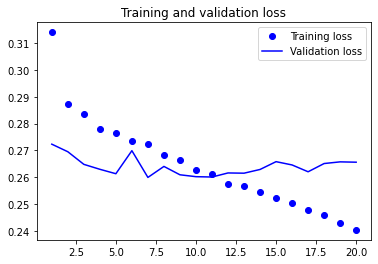

In [6]:
plot_loss(history)

In [7]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20, 
                    validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 51s 99ms/step - loss: 0.5160 - val_loss: 0.2907
Epoch 2/20
500/500 [==============================] - 51s 103ms/step - loss: 0.3094 - val_loss: 0.2787
Epoch 3/20
500/500 [==============================] - 50s 101ms/step - loss: 0.2974 - val_loss: 0.2754
Epoch 4/20
500/500 [==============================] - 49s 98ms/step - loss: 0.2927 - val_loss: 0.2728
Epoch 5/20
500/500 [==============================] - 48s 96ms/step - loss: 0.2930 - val_loss: 0.2706
Epoch 6/20
500/500 [==============================] - 48s 97ms/step - loss: 0.2899 - val_loss: 0.2694
Epoch 7/20
500/500 [==============================] - 48s 97ms/step - loss: 0.2881 - val_loss: 0.2684
Epoch 8/20
500/500 [==============================] - 48s 95ms/step - loss: 0.2857 - val_loss: 0.2664
Epoch 9/20
500/500 [==============================] - 48s 96ms/step - loss: 0.2865 - val_loss: 0.2658
Epoch 10/20
500/500 [==============================] - 48s 96ms/step - loss: 0.2

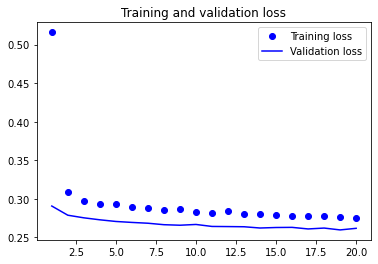

In [8]:
plot_loss(history)

In [9]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0003), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20, 
                    validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 49s 97ms/step - loss: 0.3375 - val_loss: 0.2789
Epoch 2/20
500/500 [==============================] - 50s 99ms/step - loss: 0.2932 - val_loss: 0.2748
Epoch 3/20
500/500 [==============================] - 50s 100ms/step - loss: 0.2862 - val_loss: 0.2694
Epoch 4/20
500/500 [==============================] - 47s 95ms/step - loss: 0.2837 - val_loss: 0.2686
Epoch 5/20
500/500 [==============================] - 47s 95ms/step - loss: 0.2814 - val_loss: 0.2659
Epoch 6/20
500/500 [==============================] - 47s 95ms/step - loss: 0.2780 - val_loss: 0.2650
Epoch 7/20
500/500 [==============================] - 47s 95ms/step - loss: 0.2784 - val_loss: 0.2654
Epoch 8/20
500/500 [==============================] - 47s 95ms/step - loss: 0.2776 - val_loss: 0.2674
Epoch 9/20
500/500 [==============================] - 47s 95ms/step - loss: 0.2722 - val_loss: 0.2660
Epoch 10/20
500/500 [==============================] - 47s 95ms/step - loss: 0.27

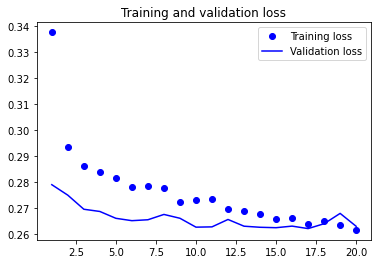

In [10]:
plot_loss(history)